# Get Reserve Info

In this notebook, we gather information regarding the types of tokens present in Aave.

In [1]:
#import packages
import requests
import json
import pandas as pd
import seaborn as sns
import cryptocompare
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import missingno as msno
from IPython.display import HTML
import matplotlib.dates as md
import time
import math

### Get Rate Data

We start by gathering data for borrow and deposit rates for each currency. The data has a row for every time a rate was updated for a given currency.

In [2]:
lastTime='0'
token_data=[]
#loop until no more data left
while(1):
    try:
        #set query
        query="""
        {
            reserveParamsHistoryItems(first: 1000 orderBy: timestamp where:{timestamp_gt:"""+lastTime+"""}) {
            timestamp
            reserve{
                symbol
            }
            variableBorrowRate
            stableBorrowRate
            liquidityRate
            }
        }
        """
        #make request
        url = 'https://api.thegraph.com/subgraphs/name/aave/protocol-v2'
        request = requests.post(url,json={'query':query})
        #store data
        token_data.extend(request.json()['data']['reserveParamsHistoryItems'])
        lastTime = str(request.json()['data']['reserveParamsHistoryItems'][-1]['timestamp'])
    except Exception as e:
        #exit when no more data left to get
        print(e)
        break

#create borrows data frame
df_tokens = pd.DataFrame(token_data)
df_tokens.info()

list index out of range
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545441 entries, 0 to 545440
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   liquidityRate       545441 non-null  object
 1   reserve             545441 non-null  object
 2   stableBorrowRate    545441 non-null  object
 3   timestamp           545441 non-null  int64 
 4   variableBorrowRate  545441 non-null  object
dtypes: int64(1), object(4)
memory usage: 20.8+ MB


In [3]:
df_tokens.head()

,liquidityRate,reserve,stableBorrowRate,timestamp,variableBorrowRate
0,0,{'symbol': 'WETH'},30000000000000000000000000,1606777900,0
1,0,{'symbol': 'WETH'},30000000000000000000000000,1606778006,0
2,0,{'symbol': 'AAVE'},0,1606836555,0
3,0,{'symbol': 'WETH'},30000000000000000000000000,1606836949,0
4,0,{'symbol': 'WETH'},30000000000000000000000000,1606837339,0


### Cleaning

We adjust the values for the rates by a scaler to represent these as percentages.

In [4]:
#adjust rates to percentages
df_tokens['liquidityRate']= df_tokens['liquidityRate'].astype(float)/1e27*100
df_tokens['variableBorrowRate']= df_tokens['variableBorrowRate'].astype(float)/1e27*100
df_tokens['stableBorrowRate']= df_tokens['stableBorrowRate'].astype(float)/1e27*100

df_tokens[['liquidityRate','variableBorrowRate','stableBorrowRate']]

,liquidityRate,variableBorrowRate,stableBorrowRate
0,0.000000,0.000000,3.000000
1,0.000000,0.000000,3.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,3.000000
4,0.000000,0.000000,3.000000
...,...,...,...
545436,2.596734,9.385090,0.000000
545437,0.042417,0.908173,1.297390
545438,4.541193,5.532024,12.532024
545439,4.542193,5.533254,12.533254


Next, we transform the reserve column to string.

In [5]:
#define function to parse reserves
def getReserves(row):
    reserve = row['reserve']['symbol']
    return reserve
 
#apply to reserve column to convert to string
df_tokens['reserve'] = df_tokens.apply(lambda x: getReserves(x), axis=1)

Finally, we save the data to a csv file.

In [6]:
#save to csv file
df_tokens.to_csv("rates.csv",index=False)

### Analysis

We will perform some basis analysis on CRV data. We subset the dataset so only rows regarding CSV are included.

In [7]:
#subset crv
df_crv = df_tokens[df_tokens['reserve']=='CRV']
df_crv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12148 entries, 17281 to 545421
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   liquidityRate       12148 non-null  float64
 1   reserve             12148 non-null  object 
 2   stableBorrowRate    12148 non-null  float64
 3   timestamp           12148 non-null  int64  
 4   variableBorrowRate  12148 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 569.4+ KB


We create a boxplot to show the distribution of liquidity rates for CSV.

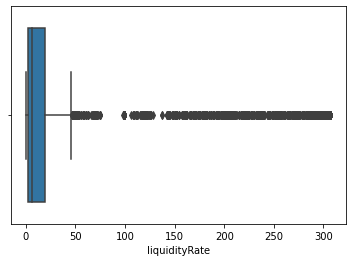

In [8]:
#create boxplot
sns.boxplot(x=df_crv['liquidityRate'].astype(float))
plt.show()

### Get Token Data

Next, we will create a dataset where each row is a unique currency, and the columns are different metrics to describe it.

In [9]:
#set query
query="""
        {
            reserves{
                id
                pool{
                    id
                }
                symbol
                decimals
                usageAsCollateralEnabled
                borrowingEnabled
                stableBorrowRateEnabled
                reserveLiquidationThreshold
                reserveLiquidationBonus
            }
        }
        """

#make request
url = 'https://api.thegraph.com/subgraphs/name/aave/protocol-v2'
request = requests.post(url,json={'query':query})

#save result as dataframe
df_token_data = pd.DataFrame(request.json()['data']['reserves'])
df_token_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   borrowingEnabled             52 non-null     bool  
 1   decimals                     52 non-null     int64 
 2   id                           52 non-null     object
 3   pool                         52 non-null     object
 4   reserveLiquidationBonus      52 non-null     object
 5   reserveLiquidationThreshold  52 non-null     object
 6   stableBorrowRateEnabled      52 non-null     bool  
 7   symbol                       52 non-null     object
 8   usageAsCollateralEnabled     52 non-null     bool  
dtypes: bool(3), int64(1), object(5)
memory usage: 2.7+ KB


### Cleaning

First, we convert the pool column to string.

In [10]:
#function to parse pool
def getPool(row):
    pool = row['pool']['id']
    return pool

#apply to convert pool column to string
df_token_data['pool'] = df_token_data.apply(lambda x: getPool(x), axis=1)

Next, we convert the numeric columns to floats.

In [11]:
#change numeric columns to type float
df_token_data['reserveLiquidationBonus']=df_token_data['reserveLiquidationBonus'].astype(float)
df_token_data['reserveLiquidationThreshold']=df_token_data['reserveLiquidationThreshold'].astype(float)

In [12]:
df_token_data.head()

,borrowingEnabled,decimals,id,pool,reserveLiquidationBonus,reserveLiquidationThreshold,stableBorrowRateEnabled,symbol,usageAsCollateralEnabled
0,True,18,0x0000000000085d4780b73119b644ae5ecd22b3760xb5...,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,10500.0,8250.0,True,TUSD,True
1,False,18,0x004375dff511095cc5a197a54140a24efef3a4160xac...,0xacc030ef66f9dfeae9cbb0cd1b25654b82cfa8d5,11500.0,7000.0,False,AmmUniWBTCUSDC,True
2,True,18,0x03ab458634910aad20ef5f1c8ee96f1d6ac549190xb5...,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,0.0,0.0,False,RAI,False
3,True,2,0x056fd409e1d7a124bd7017459dfea2f387b6d5cd0xb5...,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,0.0,0.0,False,GUSD,False
4,True,18,0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e0xb5...,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,11000.0,6000.0,False,YFI,True


Finally, we save the data as a csv file.

In [13]:
#save to csv file
df_token_data.to_csv("tokens.csv",index=False)

### Analysis

Below, we create a bar chart to show the number of coins that have borrowing enabled. The majority of coins have borrowing enabled.

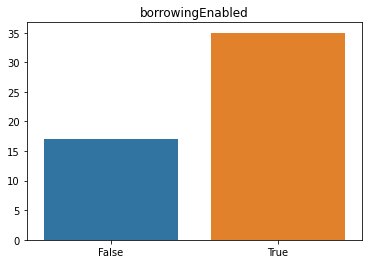

In [14]:
#get value counts for columns
metric='borrowingEnabled'
stats = df_token_data[metric].value_counts()

#create barplot
sns.barplot(x=stats.index,y=stats.values)
plt.title(metric)
plt.show()

Next, we examine which coins can be used as collateral. The vast majority coins are available to be used as collateral.

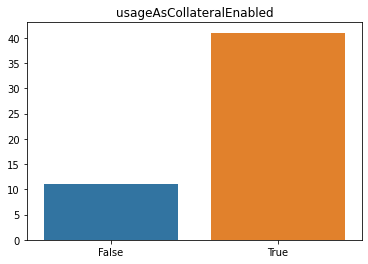

In [15]:
#get value counts for columns
metric='usageAsCollateralEnabled'
stats = df_token_data[metric].value_counts()

#create barplot
sns.barplot(x=stats.index,y=stats.values)
plt.title(metric)
plt.show()

Now, we examine the number of coins that have stable borrow rates enabled. We can see that most coins do not have stable borrow rates enabled.

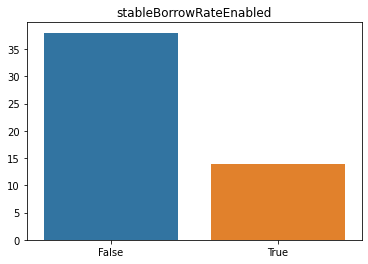

In [16]:
#get value counts for columns
metric='stableBorrowRateEnabled'
stats = df_token_data[metric].value_counts()

#create barplot
sns.barplot(x=stats.index,y=stats.values)
plt.title(metric)
plt.show()

We create a swarmplot to show the distribution of reserve liquidation bonuses. It seems that this column is not continous. Many coins have a bonus of 0, whereas the rest of coins have a bonus ranging from 10,000 - 12,000.

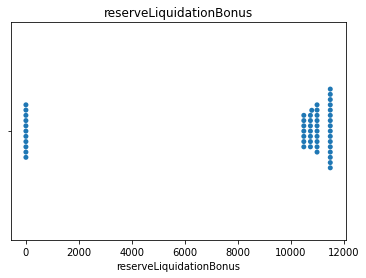

In [17]:
#create swarmplot
sns.swarmplot(data=df_token_data,x='reserveLiquidationBonus')
plt.title('reserveLiquidationBonus')
plt.show()

Finally, we analyze the reserve liquidation threshold for coins. Many have a threshold of 0, where the rest have a threshold centered around 7,000.

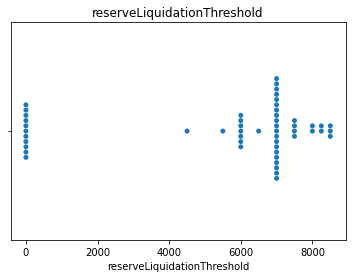

In [18]:
#create swarmplot
sns.swarmplot(data=df_token_data,x='reserveLiquidationThreshold')
plt.title('reserveLiquidationThreshold')
plt.show()